# Non-dispersive linear media
[Link to tutorial](https://octopus-code.org/documentation/13/tutorial/maxwell/run02/)

In [ ]:
import holoviews as hv

from postopus import Run

hv.extension("bokeh")  # Allow for interactive plots

## Including non-disperive linear media objects


In [ ]:
!mkdir -p 4-non-dispersive-linear-objects

In [ ]:
cd 4-non-dispersive-linear-objects

An arbitrary number of linear medium shapes can be placed inside simulation
box.  Linear media are defined as a separate system type, for example:

```
%Systems
 'Maxwell' | maxwell
 'Medium'  | linear_medium
%
```

The object shape can be defined in two ways, which are given by the variable
[LinearMediumBoxShape](https://www.octopus-code.org/documentation//13/variables/maxwell/linearmediumboxshape): if set to medium_parallelepiped, the
parallelepiped box will be defined by its center, and size in each dimension
through the [LinearMediumBoxSize](https://www.octopus-code.org/documentation//13/variables/maxwell/linearmediumboxsize) block; if the box shape is
defined as medium_box_file, the box shape will be read from an external
geometry file in [OFF](https://en.wikipedia.org/wiki/OFF_(file_format)) format,
defined through the variable [LinearMediumBoxFile](https://www.octopus-code.org/documentation//13/variables/maxwell/linearmediumboxfile).

In this tutorial, we will simulate light propagation though a spherical lens,
for which we need to provide an OFF file representing a suitable shape. There
are many software packages around to generate such files, but we recommend
[openSCAD](https://www.openscad.org/index.html) and `ctmconv` which is part
of [OpenCTM](https://openctm.sourceforge.net/).


<div class="alert alert-block alert-info"> <b>NOTE</b>
In Debian style systems, these can be installed using <br>
<code>apt-get install openscad <br>apt-get install openctm-tools </code>
</div>

OpenSCAD provides its own scripting language for creating geometries, which can
be created in a GUI, but also can be rendered on the command line. Here we will
use the following code to create a simple lens from the intersection of two
spheres and shift its position to the negative x-axis with openSCAD, using the
following script:


In [ ]:
%%writefile lens.scad

$fs=2.0;
$fa=2.0;
translate([-10,0,0]) {
intersection(){
  translate([-8,0,0]) sphere(r=10);
  translate([ 8,0,0]) sphere(r=10);
};
};

In [ ]:
!openscad -o lens.off lens.scad

For details on the syntax of this, see the openSCAD [tutorials]("https://www.openscad.org/documentation.html").
This creates the following lens:
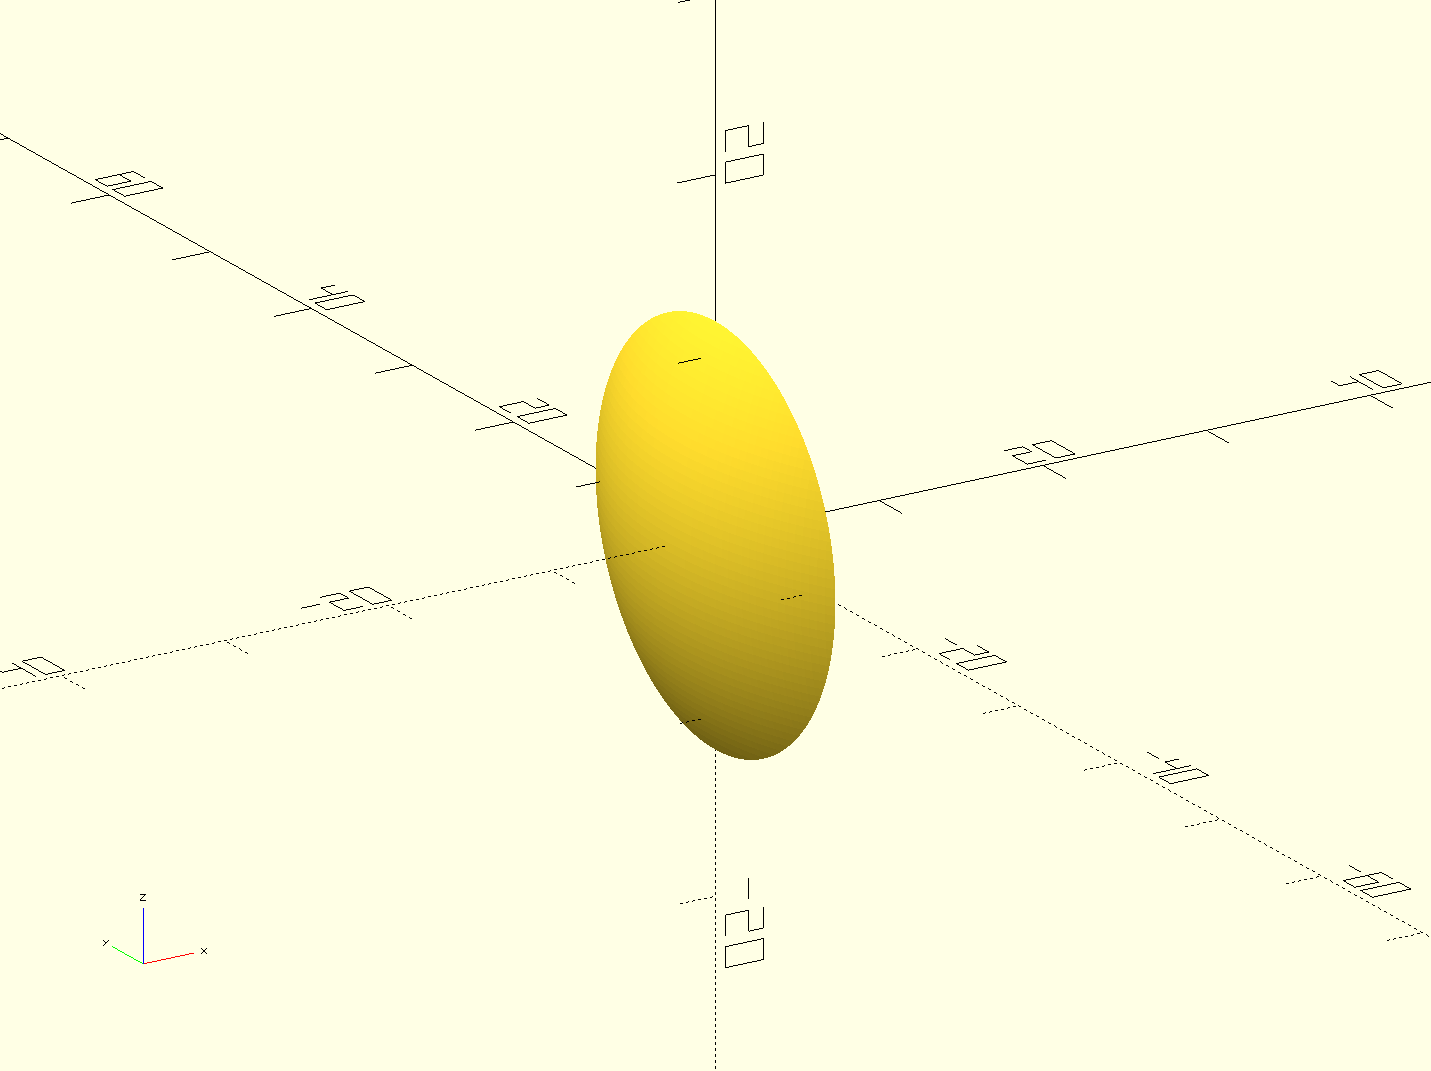

<details>
    <summary>If you want to manipulate your OFF file with ctmconv, click here.</summary>
    The <code>OFF</code> files, generated by openSCAD are malformed. If you want to further manipulate them with <code>ctmconv</code>, the header needs to be fixed:<br>
    <code>
    OFF 1162 2320 0<br>
    1.81312 4.79828 5.90861<br>
    1.73416 3.80751 6.86969<br>
    1.98506 3.84776 5.90861<br>
    1.72673 7.81373 -0.993913<br>
    1.39732 8.75085 -0.993913<br>
    1.41584 8.75777 0<br>
    ...
    </code><br>
    The first line needs to be <code>OFF</code> only, and the first line of the data block needs to contain the number of vertices, planes and (optional) connections.
    You can add comments (starting with <code>OFF</code> of empty lines are allowed after the header).<br>
    <code>
    OFF<br>
    # This is a lens (generated with OpenSCAD)<br>
    <br>
    1162 2320 0<br>
    1.81312 4.79828 5.90861<br>
    1.73416 3.80751 6.86969<br>
    1.98506 3.84776 5.90861<br>
    1.72673 7.81373 -0.993913<br>
    1.39732 8.75085 -0.993913<br>
    1.41584 8.75777 0<br>
    ...<br>
    </code>
</details>





Now we have the OFF file, let's consider the
electromagnetic properties of the medium. These must be defined in the [LinearMediumProperties](https://www.octopus-code.org/documentation//13/variables/maxwell/linearmediumproperties) block, which specifies the relative electric
permittivity, relative magnetic permeability, and the electric and magnetic
conductivities (for lossy media). In addition to
adding the linear_medium system, we need to switch the [MaxwellHamiltonianOperator](https://www.octopus-code.org/documentation//13/variables/hamiltonian/maxwellhamiltonianoperator) to `faraday_ampere_medium`.

As a linear medium will scatter waves in all directions, there need to be
absorbing boundary conditions to avoid spurious reflections on the box
boundaries. For this purpose, we change the [MaxwellAbsorbingBoundaries](https://www.octopus-code.org/documentation//13/variables/time-dependent/propagation/maxwellabsorbingboundaries) block to mask in all directions, to damp the
field at the boundaries by multiplying it with a scalar mask function.  The
width of this mask [MaxwellABMaskWidth](https://www.octopus-code.org/documentation//13/variables//maxwellabmaskwidth) is set to 5 Bohr.

As a consequence of the additional region for the absorbing boundary condition,
we have to increase the box size. Therefore, the `lsize_mx` value is
now 20.0 (13.0 Bohr for propagation region plus 2.0 Bohr for the incident wave
boundaries plus 5.0 Bohr for absorbing boundary conditions).

Finally, as non-dispersive linear media are static,
<code><a href=https://www.octopus-code.org/documentation//13/variables/time-dependent/propagation/tdsystempropagator>TDSystemPropagator</a> = static</code>, which is the default option, must be set for the medium,
while the Maxwell system needs to be set to `exp_mid`.  A possible
  input file to run this simulation, then, would be the following:

In [ ]:
%%writefile inp

stdout = 'stdout.txt'
stderr = 'stderr.txt'

CalculationMode = td
ExperimentalFeatures = yes

%Systems
 'Maxwell' | maxwell
 'Medium'  | linear_medium
%

Maxwell.ParDomains = auto
Maxwell.ParStates  = no

# free maxwell box limit of 13.0 plus 2.0 for the incident wave boundaries with
# der_order times dx_mx (here: der_order = 4) plus 5.0 for absorbing boundary conditions

lsize_mx = 20.0
dx_mx    = 0.5

BoxShape = parallelepiped

%Lsize
 lsize_mx | lsize_mx | lsize_mx
%

%Spacing
 dx_mx | dx_mx | dx_mx
%

LinearMediumBoxShape = medium_box_file
LinearMediumBoxFile = "lens.off"
%LinearMediumProperties
 5.0 | 1.0 | 0.0 | 0.0
%

MaxwellHamiltonianOperator = faraday_ampere_medium

%MaxwellBoundaryConditions
 plane_waves | plane_waves | plane_waves
%

%MaxwellAbsorbingBoundaries
 mask | mask | mask
%

MaxwellABWidth = 5.0

Maxwell.TDSystemPropagator = prop_expmid

timestep = 1 / ( sqrt(c^2/dx_mx^2 + c^2/dx_mx^2 + c^2/dx_mx^2) )
Maxwell.TDTimeStep = timestep
Medium.TDTimeStep = timestep/2
TDPropagationTime = 150*timestep

OutputFormat = plane_x + plane_y + plane_z + axis_x + axis_y + axis_z

%MaxwellOutput
 electric_field
%

MaxwellOutputInterval = 25
MaxwellTDOutput = maxwell_energy + maxwell_total_e_field + maxwell_total_b_field


lambda1 = 10.0
omega1  = 2 * pi * c / lambda1
k1_x    = omega1 / c
E1_z    = 0.05
pw1     = 10.0
ps1_x   = - 25.0

# laser propagates in x direction
%MaxwellIncidentWaves
  plane_wave_mx_function | electric_field | 0 | 0 | E1_z | "plane_waves_function_1"
%

%MaxwellFunctions
  "plane_waves_function_1" | mxf_cosinoidal_wave | k1_x | 0    | 0 | ps1_x | 0     | 0 | pw1
%

<div class="alert alert-block alert-info"> <b>NOTE</b>
As the <code>exp_mid</code> propagator contains two algorithmic steps, it must
be clocked twice as fast as the <code>static</code> propagator and hence the
time step of the medium bust be set to half the Maxwell time step. This is
currently a workaround, and is likely to change in future releases of the code.
</div>

For this run, we use the previous incident plane wave propagating only in the
x-direction but place a medium box inside the simulation box.


In [ ]:
!octopus

In [ ]:
run = Run(".")

In [ ]:
ef = run.Maxwell.td.e_field("z=0").vz
box_shape = slice(-15, 15)
box = ef.sel(x=box_shape, y=box_shape)
hv_ds = hv.Dataset(box)
hv_im = hv_ds.to(hv.Image, kdims=["x", "y"], dynamic=True)
hv_im.options(
    cmap="seismic",
    clim=(ef.min().item(), ef.max().item()),
)
hv_im

At $t=0.21066$, it can be seen that there is a significant amount of
scattered waves which, in large parts, are scattered from the box boundaries.
This is due to making use of plane wave boundary conditions and absorbing
boundaries simultaneously, and would be less noticeable if we increase the size
of the box. In this tutorial we keep the box small to stay within a reasonable
computation time.


[Go to *5-dispersive-linear-media.ipynb*](5-dispersive-linear-media.ipynb)